In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
# from numba import jit

from matplotlib import rcParams 
rcParams['text.latex.preamble'] = r'\usepackage{amsmath}' 
rcParams['text.usetex']         = True 
rcParams['font.family']         = 'sans-serif' 
rcParams['font.sans-serif']     = ['Helvetica']
rcParams['animation.html']      = 'html5'

%matplotlib inline

### Problem 3.13

In [ ]:
def V(x,y,N=100):
    ## unitless: V = V(x,y)/V_0 | x,y = x,y/a 
    V = 0
    for n in range(N):
        V += np.exp(-(2*n+1)*np.pi*x)*np.sin((2*n+1)*np.pi*y)/(2*n+1)
        # V += np.exp(-(4*n+2)*np.pi*x)*np.sin((4*n+2)*np.pi*y)/(2*n+1)
    V *= 4/np.pi
    return V

In [ ]:
num = 100
x = np.linspace(0.0,0.1,num) # x: 0,infinity
y = np.linspace(0.0,1.0,num) # y: 0,a
X,Y = np.meshgrid(x,y)

In [ ]:
def plot3d(X,Y,N):
    fig, ax = plt.subplots(1,1,figsize=(7,7),subplot_kw=dict(projection='3d'))

    Z = V(X,Y,N)
    ax.plot_surface(X,Y,Z,cmap=plt.cm.coolwarm)

    ax.set_title(r'$N=%d$'%N,size=20)
    ax.set_xlabel(r'$x/a$',size=20,labelpad=15)
    ax.set_ylabel(r'$y/a$',size=20,labelpad=10)
    ax.set_zlabel(r'$V/V_0$',size=20,labelpad=10,rotation=45)
    ax.zaxis.set_rotate_label(False)
    
    ax.tick_params(axis='both',which='major',labelsize=20,direction='in')
    ax.view_init(30, 30)
    
    # plt.savefig('./plots/prob3-13_%d.png'%N,bbox_inches='tight')
    plt.show()

In [ ]:
fps = 10
frn = 100
zarray = np.zeros([num,num,frn])

for i in range(1,frn+1):
    zarray[:,:,i-1] = V(X,Y,N=i)

In [ ]:
def update_plot(frame_number,zarray,plot):
    plot[0].remove()
    plot[0] = ax.plot_surface(X,Y,zarray[:,:,frame_number],cmap=plt.cm.coolwarm)
    plot[1] = ax.set_title(r'$N=%d$'%frame_number,size=20)
    
fig, ax = plt.subplots(1,1,figsize=(7,7),subplot_kw=dict(projection='3d'))
ax.set_xlim(min(x),max(x))
ax.set_ylim(min(y),max(y))
ax.set_zlim(-1.3,1.3)
ax.zaxis.set_rotate_label(False)
ax.view_init(30,30)

ax.set_xlabel(r'$x/a$',size=20,labelpad=15)
ax.set_ylabel(r'$y/a$',size=20,labelpad=10)
ax.set_zlabel(r'$V/V_0$',size=20,labelpad=10)

ax.tick_params(axis='both',which='major',labelsize=20,direction='in')

plot = [ax.plot_surface(X,Y,zarray[:,:,0],cmap=plt.cm.coolwarm,rstride=1,cstride=1),
        ax.set_title(r'$N=%d$'%1,size=20)]
ani = animation.FuncAnimation(fig,update_plot,frn,fargs=(zarray,plot),interval=1000/fps)

In [ ]:
name = './plots/animation'
ani.save(name+'.gif',writer='imagemagick',fps=fps)

In [ ]:
%%bash
convert ./plots/animation.gif -fuzz 5%% -layers Optimize ./plots/animation.gif

### Problem 3.16

In [ ]:
def V(x,y,z=0.5,N=50,M=50):
    V = 0
    for n in range(N+1):
        v = 0
        for m in range(M+1):
            v += np.sin((2*m+1)*np.pi*y)*np.sinh(np.pi*np.sqrt((2*n+1)**2+(2*m+1)**2)*z)/np.sinh(np.pi*np.sqrt((2*n+1)**2+(2*m+1)**2))/(2*m+1)
        v *= np.sin((2*n+1)*np.pi*x)/(2*n+1)
        V += v
    V *= 16/np.pi**2
    return V

In [ ]:
num = 100
x = np.linspace(0.0,1.0,num) # x: 0,infinity
y = np.linspace(0.0,1.0,num) # y: 0,a
X,Y = np.meshgrid(x,y)

In [ ]:
def plot3d(X,Y,z):
    fig, ax = plt.subplots(1,1,figsize=(7,7),subplot_kw=dict(projection='3d'))

    ax.plot_surface(X,Y,V(X,Y,z),cmap=plt.cm.coolwarm)

    ax.set_title(r'$z=%.1f$'%z,size=20)
    ax.set_xlabel(r'$x/a$',size=20,labelpad=15)
    ax.set_ylabel(r'$y/a$',size=20,labelpad=10)
    ax.set_zlabel(r'$V/V_0$',size=20,labelpad=20,rotation=45)
    ax.zaxis.set_rotate_label(False)
    
    ax.tick_params(axis='both',which='major',labelsize=20,direction='in')
    ax.view_init(30, -60)
    
    plt.savefig('./plots/prob3-16_%s.png'%str(round(z,2)).replace('.','-'),bbox_inches='tight')
    plt.show()

In [ ]:
z = np.linspace(0.0,1.0,6)
print(z)
for _ in z:
    plot3d(X,Y,_)

In [ ]:
def summ(x):
    res = 0
    for n in range(10):
        res += np.sin((2*n+1)*x)/(2*n+1)
    return res*4/np.pi
print(summ(np.linspace(0.0,1.0,10))**2)

### Finite Difference and Relaxation

In [2]:
# @jit(nopython=True)
def update(V):
    V_new = np.copy(V)
    shape = np.shape(V)
    h = X[0,1]-X[0,0]
    for i in range(1,shape[0]-1):
        for j in range(1,shape[1]-1):
            if (Y[i,j] >= 0.25 and Y[i,j] <= 0.75) and ((X[i,j] >= 0.2 and X[i,j] <= 0.3) or (X[i,j] >= 0.7 and X[i,j] <= 0.8)):
                continue
            V_new[i,j] = (V[i+1,j] + V[i-1,j] + V[i,j+1] + V[i,j-1])/4.0
            # print(rho(X[i,j],Y[i,j]))
    return V_new

In [3]:
def plot3d(X,Y,V,N=-1):
    fig, ax = plt.subplots(1,1,figsize=(7,7),subplot_kw=dict(projection='3d'))

    ax.plot_surface(X,Y,V,cmap=plt.cm.coolwarm)

    ax.set_xlabel(r'$x/a$',size=20,labelpad=15)
    ax.set_ylabel(r'$y/a$',size=20,labelpad=10)
    ax.set_zlabel(r'$V/V_0$',size=20,labelpad=15,rotation=45)
    ax.zaxis.set_rotate_label(False)
    if N >= 0:
        ax.set_title(r'$N=%d$'%N,size=20)
    ax.set_title('Parallel plate capacitor',size=30)
    
    ax.tick_params(axis='both',which='major',labelsize=20,direction='in')
    ax.view_init(30,30)
    
    # plt.savefig('./plots/prob3-13_%d.png'%N,bbox_inches='tight')
    plt.show()

44


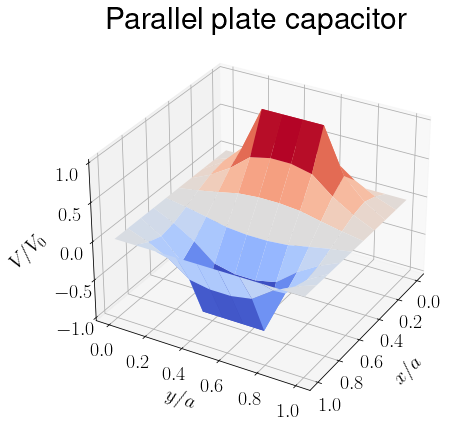

In [78]:
N = 10 # defines grid spacing
x = np.linspace(0.0,1.0,N)
y = np.linspace(0.0,1.0,N)

X,Y = np.meshgrid(x,y)
V = np.zeros(np.shape(X))

def initial(x,y):
    if (y >= 0.25 and y <= 0.75):
        if (x >= 0.2 and x <= 0.3):
            return 1.0
        elif x >= 0.7 and x <= 0.8:
            return -1.0
        else:
            return 0.0
    else:
        return 0.0
    
def set_initial(shape):
    V = np.zeros(shape)
    for i in range(shape[0]):
        for j in range(shape[1]):
            V[i,j] = initial(X[i,j],Y[i,j])
    return V

V = set_initial(np.shape(X))
# plot3d(X,Y,V)
# print(X)
# print(Y)
# print(V)

i = 0
while True:
    i += 1
    V_new = update(V)
    if np.all(abs(V_new - V) < 1e-5):
        print(i)
        break
    V = V_new
plot3d(X,Y,V)